# Titanic Kaggle Competition
This is a notebook aiming to predict deaths on the titanic based on various passenger information for the ["getting started" kaggle competition](https://www.kaggle.com/competitions/titanic/data)

## Table of Contents

- [1 - Packages](#1)
- [2 - Import Data](#2)
- [3 - Format Data](#3)
    - [3.1 - Encode Sex](#3-1)
    - [3.2 - Encode Age](#3-2)
    - [3.3 - One-Hot Encode Port of Embarkation](#3-3)
    - [3.4 - Encode Ticket Number](#3-4)
    - [3.5 - One-Hot Encode Cabin Number Letters](#3-5)
    - [3.6 - Make Cabin Numbers Separate Feature](#3-6)
    - [3.7 - Trim Fare Outliers](#3-7)
    - [3.8 - One-Hot Encode Most Common Names](#3-8)
- [4 - Build the Model](#4)
    - [4.1 - Plot Survival Distribution](#4-1)
    - [4.2 - Define Features](#4-2)
    - [4.3 - Test Different Built-in Classifiers](#4-3)
    - [4.4 - Grid Search of Hyperparameters using XGB](#4-4)
    - [4.5 - Check for Over-Fitting to Training Set](#4-5)
    - [4.6 - Visualize Feature Importance](#4-6)
    - [4.7 - Perform SHAP Analysis](#4-7)
    - [4.8 - Hyperparameter Optimization with Filtered Feature List](#4-8)
- [5 - Apply Best Model to Test Data](#5)

<a name='1'></a>
## 1 - Packages

In [1127]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import uniform, randint
from sklearn.impute import SimpleImputer
import re
import shap
from IPython.display import display, HTML

In [1129]:
display(HTML('''
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
'''))

<a name='2'></a>
## 2 - Import Data

In [1132]:
# Import training data
df_train = pd.read_csv('train.csv') # shows survivorship based on variety of factors
df_test=pd.read_csv('test.csv') # test data that excludes survivorship

<a name='3'></a>
## 3 - Format Data

Need to convert non-numerical classifiers into binary encoded or one-hot encoded variables for both test and train. Also need to clean up data with missing or undefined entries.

<a name='3-1'></a>
### 3.1 - Encode Sex 

In [1136]:
# initialize encoder
encoder = LabelEncoder()
# Convert 'male'/'female' to 0/1 for training and test set
df_train['Sex'] = encoder.fit_transform(df_train['Sex'])
df_test['Sex'] = encoder.fit_transform(df_test['Sex'])

<a name='3-2'></a>
### 3.2 - Encode Age 

In [1140]:
# Age have some undefined elements, replace with mean for training and test set, add indicator column 'Age_missing'
age_imputer = SimpleImputer(strategy='mean', add_indicator=True)
age_imputed = age_imputer.fit_transform(df_train[['Age']])
df_train['Age'] = age_imputed[:, 0]
df_train['Age_missing'] = age_imputed[:, 1].astype(int) 

age_imputed_test = age_imputer.transform(df_test[['Age']]) # Using transform instead of fit_transform to make consistent with training
df_test['Age'] = age_imputed_test[:, 0]
df_test['Age_missing'] = age_imputed_test[:, 1].astype(int) 

<a name='3-3'></a>
### 3.3 - One-Hot Encode Port of Embarkation

In [1143]:
# convert Embarked into 1-hot encoded columns. a few nan columns are 0 for all three categories
dummies = pd.get_dummies(df_train['Embarked'], prefix='Embarked')
dummies = dummies.astype('Int64')
df_train = pd.concat([df_train.drop('Embarked', axis=1), dummies], axis=1)

# repeat for test set
dummies = pd.get_dummies(df_test['Embarked'], prefix='Embarked')
dummies = dummies.astype('Int64')
df_test = pd.concat([df_test.drop('Embarked', axis=1), dummies], axis=1)

Initial models indicate that origin of embarkment does correlate with survival, with C and Q having positive correlation and S being negative. Retry with ordinal encoding.

In [1146]:
ordinal_map = {
    'Embarked_S': 1,
    'Embarked_Q': 2,
    'Embarked_C': 3,
}

one_hot_columns = df_train.filter(like='Embarked_').columns.tolist()
df_train['Embarked_Ordinal'] = df_train[one_hot_columns].idxmax(axis=1).map(ordinal_map)
df_test['Embarked_Ordinal'] = df_test[one_hot_columns].idxmax(axis=1).map(ordinal_map)

<a name='3-4'></a>
### 3.4 - Encode Ticket Number

In [1149]:
# Train set
df_train['Ticket'] = df_train['Ticket'].str.extract(r'(\d+)').astype('Int64')
imputer = SimpleImputer(strategy='mean', add_indicator=True)
Ticket_imputed_train = imputer.fit_transform(df_train[['Ticket']])
df_train['Ticket'] = Ticket_imputed_train[:, 0]
df_train['Ticket_missing'] = Ticket_imputed_train[:, 1].astype(int)
df_train['Ticket'] = np.log(df_train['Ticket'])

# Test set (use transform, not fit_transform!)
df_test['Ticket'] = df_test['Ticket'].str.extract(r'(\d+)').astype('Int64')
Ticket_imputed_test = imputer.transform(df_test[['Ticket']])
df_test['Ticket'] = Ticket_imputed_test[:, 0]
df_test['Ticket_missing'] = Ticket_imputed_test[:, 1].astype(int)
df_test['Ticket'] = np.log(df_test['Ticket'])


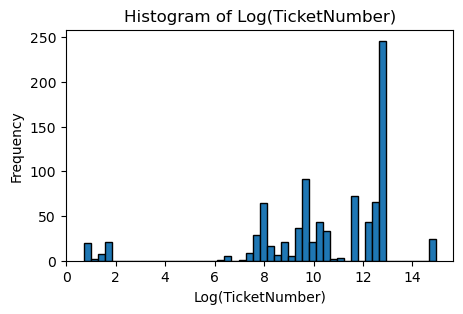

In [1273]:
plt.figure(figsize=(5, 3))
plt.hist(df_train['Ticket'], bins=50, edgecolor='black')
plt.title("Histogram of Log(TicketNumber)")
plt.xlabel("Log(TicketNumber)")
plt.ylabel("Frequency")
plt.show()

`df_train['Ticket']` appears to cluster around values with ~1, ~8, ~10, and ~12 digits. Taking the Log should help to keep the values smaller but capture this clustering.

<a name='3-5'></a>
### 3.5 - One-Hot Encode Cabin Number Letters

In [1155]:
# For Cabin Numbers, create new column with cabin letters, keeping only the first letter. Then convert to one-hot encoding
df_train['CabinLet'] = df_train['Cabin'].apply(lambda x: re.sub(r'[^A-Za-z]', '', str(x))[0] if isinstance(x, str) and len(re.sub(r'[^A-Za-z]', '', str(x))) > 0 else '')
dummies2 = pd.get_dummies(df_train['CabinLet'], prefix='CL')
dummies2 = dummies2.astype('Int64')
df_train = pd.concat([df_train, dummies2], axis=1)

# Repeat for test set
df_test['CabinLet'] = df_test['Cabin'].apply(lambda x: re.sub(r'[^A-Za-z]', '', str(x))[0] if isinstance(x, str) and len(re.sub(r'[^A-Za-z]', '', str(x))) > 0 else '')
dummies2 = pd.get_dummies(df_test['CabinLet'], prefix='CL')
dummies2 = dummies2.astype('Int64')
df_test = pd.concat([df_test, dummies2], axis=1)
df_test['CL_T']=0

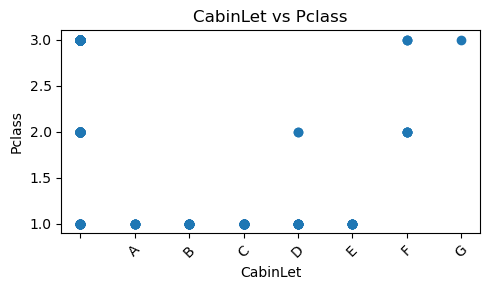

In [1157]:
# Sort df_test by column 'CabinLet' alphabetically
df_sorted = df_test.sort_values(by='CabinLet')

plt.figure(figsize=(5, 3))
plt.scatter(df_sorted['CabinLet'], df_sorted['Pclass'], marker='o')
plt.xlabel('CabinLet')
plt.ylabel('Pclass')
plt.title('CabinLet vs Pclass')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`CabinLet` appears to be a proxy for `Pclass`, with Cabins D and F being split among classes, and unassigned tickets spanning all three classes. Correlation between classes and cabin number letter suggests that ordinal encoding might be superior to one-hot encoding

In [1160]:
# Try ordinal encoding of CabinLet instead
ordinal_map = {
    'CL_': 0,
    'CL_A': 1,
    'CL_B': 2,
    'CL_C': 3,
    'CL_D': 4,
    'CL_E': 5,
    'CL_F': 6,
    'CL_G': 7,
    'CL_T': 0
}

one_hot_columns = df_train.filter(like='CL').columns.tolist()
df_train['CabinLet_Ordinal'] = df_train[one_hot_columns].idxmax(axis=1).map(ordinal_map)
df_test['CabinLet_Ordinal'] = df_test[one_hot_columns].idxmax(axis=1).map(ordinal_map)

<a name='3-6'></a>
### 3.6 - Make Cabin Numbers Separate Feature

In [1163]:
# For Cabin Numbers, create new column with numerical component of numbers
df_train['CabinNum'] = df_train['Cabin'].str.extract(r'(\d+)').astype('Int64')
imputer = SimpleImputer(strategy='mean', add_indicator=True)
CabinNum_imputed = imputer.fit_transform(df_train[['CabinNum']])
df_train['CabinNum'] = CabinNum_imputed[:, 0]
df_train['CabinNum_missing'] = CabinNum_imputed[:, 1].astype(int) 

# Repeat for test set
df_test['CabinNum'] = df_test['Cabin'].str.extract(r'(\d+)').astype('Int64')
CabinNum_imputed_test = imputer.transform(df_test[['CabinNum']])
df_test['CabinNum'] = CabinNum_imputed_test[:, 0]
df_test['CabinNum_missing'] = CabinNum_imputed_test[:, 1].astype(int) 

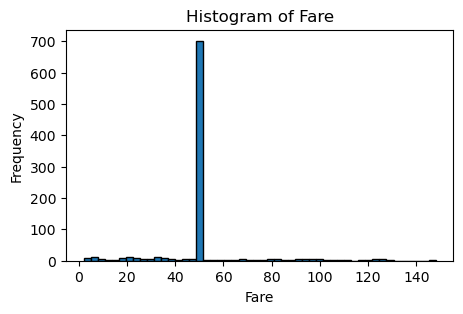

In [1165]:
plt.figure(figsize=(5, 3))
plt.hist(df_train['CabinNum'], bins=50, edgecolor='black')
plt.title("Histogram of Fare")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.show()

<a name='3-7'></a>
### 3.7 - Trim Fare Outliers

`Fare` has outliers skewing results, try to set lower and upper bound

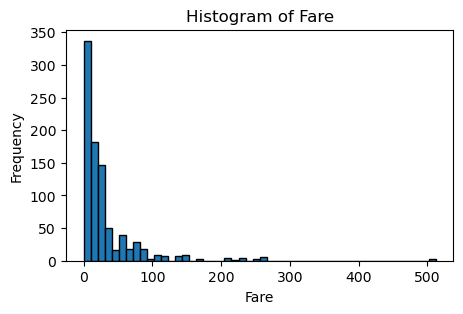

In [1169]:
plt.figure(figsize=(5, 3))
plt.hist(df_train['Fare'], bins=50, edgecolor='black')
plt.title("Histogram of Fare")
plt.xlabel("Fare")
plt.ylabel("Frequency")
plt.show()

In [1171]:
# Fare has outliers skewing results, try to set lower and upper bound
df_train['Fare'] = df_train['Fare'].clip(lower=0, upper=200)

df_test['Fare'] = df_test['Fare'].clip(lower=0, upper=200)

<a name='3-8'></a>
### 3.8 - One-Hot Encode Most Common Names

In [1174]:
# Pull out last names from the name column and one-hot encode the most frequent last names (names appearing >2 times)
df_train['LastName'] = df_train['Name'].str.split(',').str[0]
name_counts = df_train['LastName'].value_counts() # count frequency of each name
frequent_names = name_counts[name_counts > 2].index # Select names that appear 3 or more times
df_filtered = df_train[df_train['LastName'].isin(frequent_names)] # Filter original DataFrame to keep only frequent names for one-hot encoding
onehot = pd.get_dummies(df_filtered['LastName'],prefix='LN') # Create one-hot encoding for just those names
onehot_full = onehot.reindex(df_train.index, fill_value=0) # Reindex to match original DataFrame length, fill missing rows with 0s
df_train = pd.concat([df_train, onehot_full], axis=1) # Join one-hot columns to the original DataFrame

onehot = pd.get_dummies(df_filtered['LastName'],prefix='LN') # Create one-hot encoding for just those names
onehot_full = onehot.reindex(df_test.index, fill_value=0) # Reindex to match original DataFrame length, fill missing rows with 0s
df_test = pd.concat([df_test, onehot_full], axis=1) # Join one-hot columns to the original DataFrame

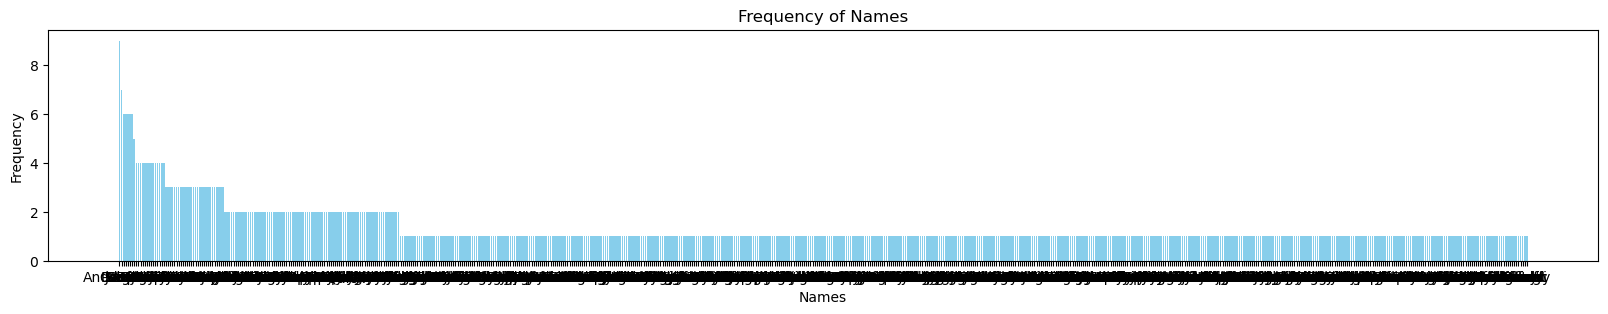

In [1175]:
plt.figure(figsize=(20, 3))
plt.bar(name_counts.index, name_counts.values, color='skyblue')
plt.xlabel('Names')
plt.ylabel('Frequency')
plt.title('Frequency of Names')
plt.show()

Many `LastNames` appear only once, but several appear two or three times. More frequent last names might correlated with survival

<a name='4'></a>
## 4 - Build the Model

<a name='4-1'></a>
### 4.1 - Plot the Survival Distribution

Want to explore distribution of classes to evaluate performance. Survivorship is somewhat imbalanced, necessitating use of F1 score to evaluate performance.

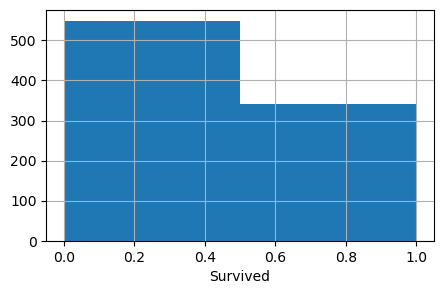

In [1181]:
plt.figure(figsize=(5,3))
df_train['Survived'].hist(bins=2)
plt.xlabel('Survived')
plt.show()

<a name='4-2'></a>
### 4.2 - Define Features

In [1184]:
#Group One-Hot encoded variable together for brevity
CabinOneHot=df_train.filter(like='CL').columns.tolist() # Removed this from features due to ordinal nature of data
EmbarkOneHot=df_train.filter(like='Embarked_').columns.tolist() # Removed this from features due to ordinal nature of data
LastNameOneHot=df_train.filter(like='LN').columns.tolist()

features =['Pclass',
            'Sex',
            'Parch',
            'SibSp',
            'Age',
            'Age_missing',
            'Ticket',
            'Ticket_missing',
            'CabinNum',
            'CabinNum_missing',
            'Fare',
            'CabinLet_Ordinal',
            'Embarked_Ordinal']+LastNameOneHot

X_OneHot=df_train[features].to_numpy(dtype='float64') # convert from pandas series ot numpy array
y_OneHot=df_train['Survived'].to_numpy(dtype='int64') # convert from pandas series ot numpy array

<a name='4-3'></a>
### 4.3 - Test Different Built-in Classifiers

In [1188]:
classifiers = [KNeighborsClassifier(),
               RandomForestClassifier(),
               GaussianNB(),
               LogisticRegression(max_iter=5000), # had to increase max
               SVC(),
               SGDClassifier(),
               XGBClassifier()
              ]
classifier_names = ['kNN','forest','GNB','LogReg', 'SVC', 'SGD', 'XGB']

In [1190]:
# Loop through classifiers
for classifier, clf_name in zip(classifiers, classifier_names): 
    
    # Calculate CV
    print(clf_name,'\t',cross_val_score(estimator=classifier, 
            X=X_OneHot, y=y_OneHot, cv=5, scoring='f1').mean(),cross_val_score(estimator=classifier, 
            X=X_OneHot, y=y_OneHot, cv=5, scoring='f1').std())

kNN 	 0.5773450850107485 0.06083440058483979
forest 	 0.754091821697085 0.03770444745045589
GNB 	 0.5791347220840185 0.00961660908204175
LogReg 	 0.7328003147461267 0.02546832666542125
SVC 	 0.45448584958030763 0.0842726325078799
SGD 	 0.6516650062223451 0.27696892641280885
XGB 	 0.7593760504329584 0.04056456563695556


All Classifiers have similar performance. Try grid search of hyperparameters for XGB

<a name='4-4'></a>
### 4.4 - Grid Search of Hyperparameters for XGB

Want to test performance of XGB using different hyperparameters. Will split into training and dev sets to also check accuracy in addition to 5-CV f1 score on the training set. Kept `learning_rate` low and `n_estimators` high and allowed other hyperparameters to vary. Will look at performance versus `n_estimators` later to ensure not overfitting

In [1192]:
# Split Data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_OneHot, y_OneHot, test_size=0.2)

# Define the model
model = XGBClassifier()

# Define the param_grid with fixed values for each hyperparameter. Will look at n_estimators later so keeping this constant
param_grid = {
    'n_estimators': [750],  
    'max_depth': [9, 10, 11, 12, 13],  
    'learning_rate': [0.004],  
    'min_child_weight': [1, 2, 3, 4],  
    'subsample': [0.8, 0.9, 1],  
    'colsample_bytree': [0.5, 0.6, 0.7]  
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='f1', cv=5, n_jobs=-1, verbose=1)
# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation f1:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test F1:", f1_score(y_test, y_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.004, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 750, 'subsample': 0.9}
Best cross-validation f1: 0.7783180103935928
Test F1: 0.7540983606557377
Test accuracy: 0.8324022346368715


In [1193]:
# Run a few times to see how test accuracy depends on data split
X_train, X_test, y_train, y_test = train_test_split(X_OneHot, y_OneHot, test_size=0.2)
print("Best cross-validation f1:", grid_search.best_score_)
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Best cross-validation f1: 0.7783180103935928
Test accuracy: 0.9497206703910615


<a name='4-5'></a>
### 4.5 - Check for Over-Fitting to Training Set

In [1196]:
# Split Data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_OneHot, y_OneHot, test_size=0.2)

cv_scores = []
test_scores = []
n_estimators_range = [x  for x in range(10, 2000, 100)]

for n in n_estimators_range:
    model_iter = XGBClassifier(
    n_estimators=n,
    colsample_bytree=0.7,
    learning_rate=0.004,
    max_depth=9,
    min_child_weight=1,
    subsample=0.9)
    
    # 5-fold cross-validation
    cv_score = cross_val_score(model_iter, X_train, y_train, cv=5, scoring='f1')
    cv_scores.append(np.mean(cv_score))
    
    # Fit on training, evaluate on test
    model_iter.fit(X_train, y_train)
    test_pred = model_iter.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_scores.append(test_acc)

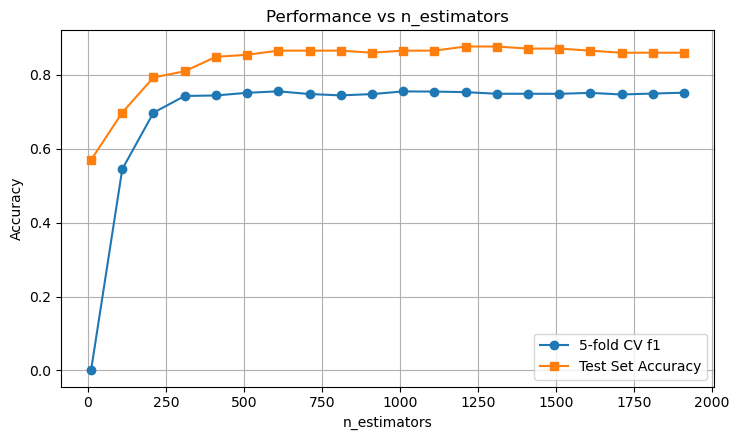

In [1197]:
plt.figure(figsize=(7.5, 4.5))
plt.plot(n_estimators_range, cv_scores, label='5-fold CV f1', marker='o')
plt.plot(n_estimators_range, test_scores, label='Test Set Accuracy', marker='s')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Performance vs n_estimators')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Training perfomance more or less saturates around 750 `n_estimators`

<a name='4-6'></a>
### 4.6 - Visualize Feature  Importance

Look at the feature importance to refine features used in training

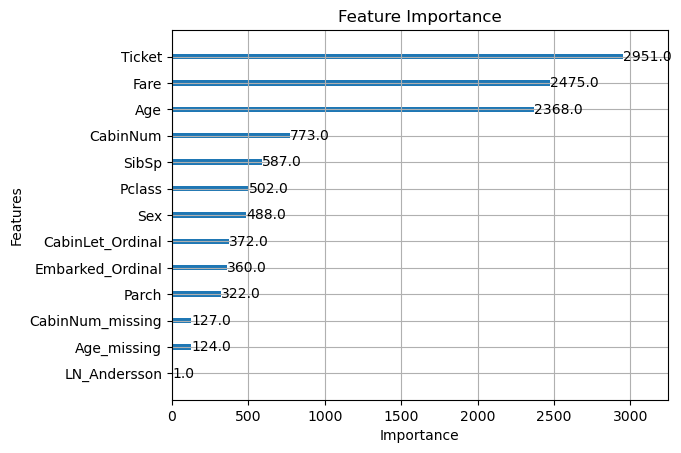

In [1253]:
X_OneHot_df = pd.DataFrame(X_OneHot, columns=features)

model = XGBClassifier(
    n_estimators=700,
    colsample_bytree=0.7,
    learning_rate=0.004,
    max_depth=5,
    min_child_weight=1,
    subsample=0.5
)

model.fit(X_OneHot_df, y_OneHot)

# Plot feature importance
plot_importance(model, importance_type='weight', max_num_features=1000)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Filter Features and compare performance with and without low-importance features

In [1255]:
# Get all feature names from your dataset
all_features = X_OneHot_df.columns.tolist()

# Get feature importances (only non-zero weights)
importance_dict = model.get_booster().get_score(importance_type='weight')

# Fill in missing features with zero importance
full_importance_dict = {feat: importance_dict.get(feat, 0) for feat in all_features}

# Create a list of feature names with 'weight' < min
low_importance_features = [feature for feature, importance in full_importance_dict.items() if importance < 27]

# Now filter from the full list of features
filtered_features = [f for f in features if f not in low_importance_features]

X_OneHot_Filtered=df_train[filtered_features].to_numpy(dtype='float64')

In [1257]:
# model_1 will be trained on original list of features (i.e., unfiltered)
model_1 = XGBClassifier(
    n_estimators=700,
    colsample_bytree=0.7,
    learning_rate=0.004,
    max_depth=5,
    min_child_weight=1,
    subsample=0.5
)

# Perform cross-validation and training split
cv_scores_1 = cross_val_score(model_1, X_OneHot, y_OneHot, cv=5, scoring='accuracy')
print(f"Accuracy for Model 1 (All Features): {np.mean(cv_scores_1)}")

X_train, X_test, y_train, y_test = train_test_split(X_OneHot, y_OneHot, test_size=0.2)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
print("Test accuracy Unfiltered:", accuracy_score(y_test, y_pred))

# model_2 will be trained on list of features without zero-importance feautres (i.e., filtered)
model_2 = XGBClassifier(
    n_estimators=700,
    colsample_bytree=0.7,
    learning_rate=0.004,
    max_depth=5,
    min_child_weight=1,
    subsample=0.5
)

# Perform cross-validation and training split
cv_scores_2 = cross_val_score(model_2, X_OneHot_Filtered, y_OneHot, cv=5, scoring='accuracy')
print(f"Accuracy for Model 2 (Filtered Feature Set): {np.mean(cv_scores_2)}")

X_train, X_test, y_train, y_test = train_test_split(X_OneHot_Filtered, y_OneHot, test_size=0.2)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print("Test accuracy Filtered:", accuracy_score(y_test, y_pred))

Accuracy for Model 1 (All Features): 0.8271922666499277
Test accuracy Unfiltered: 0.8379888268156425
Accuracy for Model 2 (Filtered Feature Set): 0.8260812252840374
Test accuracy Filtered: 0.7877094972067039


Removal of zero-importance features appears to have minimal effect on the model performance, possible slight improvement on test accuracy

<a name='4-7'></a>
### 4.7 - Perform SHAP Analysis

Look at SHAP Values of filtered feature list to better understand role of each significant feature

 99%|===================| 882/891 [00:46<00:00]        

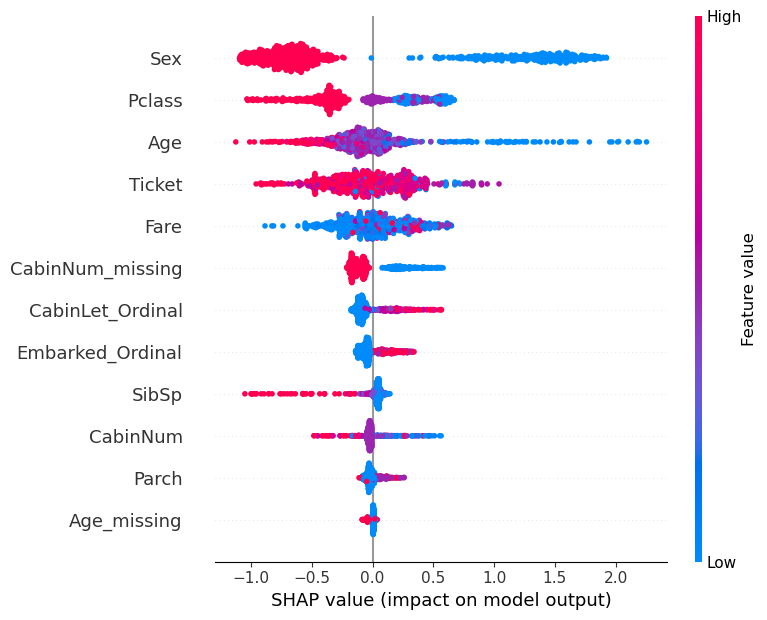

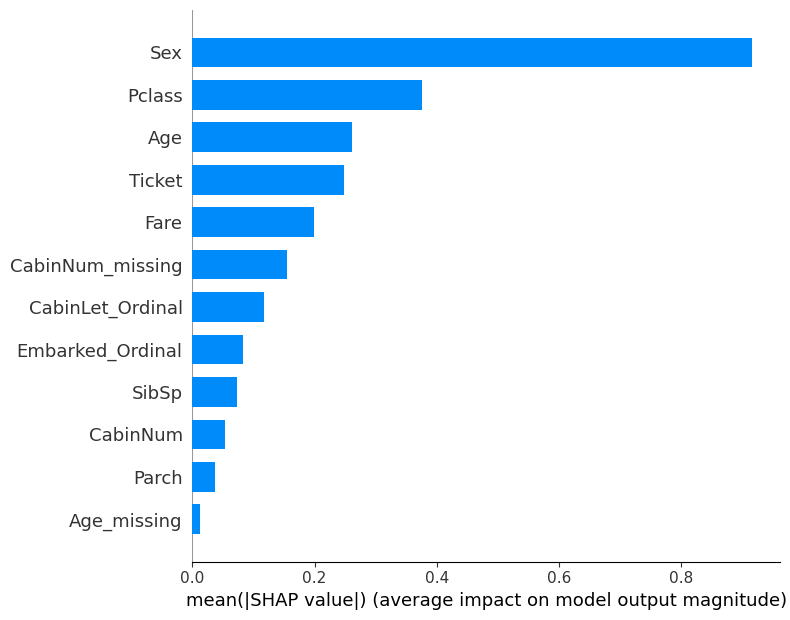

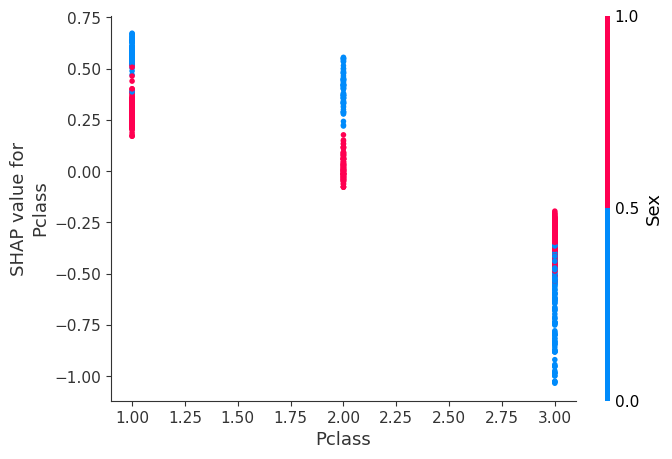

In [1215]:
X_OneHot_Filtered_df = pd.DataFrame(X_OneHot_Filtered, columns=filtered_features)

#Train the model on the filtered features
model = XGBClassifier(
    n_estimators=700,
    colsample_bytree=0.7,
    learning_rate=0.004,
    max_depth=5,
    min_child_weight=1,
    subsample=0.5
)

model.fit(X_OneHot_Filtered_df, y_OneHot)

#Explain the model's predictions with SHAP
explainer = shap.Explainer(model, X_OneHot_Filtered_df)

# Generate SHAP values
shap_values = explainer(X_OneHot_Filtered_df)

# Visualize SHAP values
shap.summary_plot(shap_values, X_OneHot_Filtered_df)

# SHAP bar plot to show feature importances
shap.summary_plot(shap_values, X_OneHot_Filtered_df, plot_type="bar")

# check dependence plot for Pclass and Sex
shap.dependence_plot("Pclass", shap_values.values, X_OneHot_Filtered_df)

plt.show()

Some interesting observations:
- Women were more likely to survive in 1st and 2nd class, but men were more likely to survive in 3rd class

<a name='4-8'></a>
### 4.8 - Hyperparameter Optimization with Filtered Feature List

In [1233]:
# Split Data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_OneHot_Filtered, y_OneHot, test_size=0.2)

# Define the model
model = XGBClassifier()

# Define the param_grid with fixed values for each hyperparameter. Will look at n_estimators later so keeping this constant
param_grid = {
    'n_estimators': [700,800,900,1000],  
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],  
    'learning_rate': [0.004],  
    'min_child_weight': [1, 2, 4, 6, 10, 50],  
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8]  
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='f1', cv=5, n_jobs=-1, verbose=1)
# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation f1:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test F1:", f1_score(y_test, y_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 6336 candidates, totalling 31680 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.004, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 700, 'subsample': 0.5}
Best cross-validation f1: 0.7698249346771183
Test F1: 0.8235294117647058
Test accuracy: 0.8491620111731844


In [1242]:
# Run a few times to see how test accuracy depends on data split
X_train, X_test, y_train, y_test = train_test_split(X_OneHot_Filtered, y_OneHot, test_size=0.2)
print("Best cross-validation f1:", grid_search.best_score_)
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

Best cross-validation f1: 0.7698249346771183
Test accuracy: 0.8994413407821229


<a name='5'></a>
## 5 - Apply best model to test data

Prepare test data for classifer. Use "filtered features", removing zero-importance features.

In [1259]:
CabinOneHot_Test=df_test.filter(like='CL').columns.tolist() # Did not end up using, used ordinal encoding instead
EmbarkOneHot_Test=df_test.filter(like='Embarked_').columns.tolist() # Did not end up using, used ordinal encoding instead
LastNameOneHot_Test=df_test.filter(like='LN').columns.tolist()

X_OneHot_Test=df_test[filtered_features].to_numpy()
X_OneHot_Test.shape

(418, 63)

Train on best model from second grid search

In [1263]:
model = XGBClassifier(
    n_estimators=750,
    colsample_bytree=0.7,
    learning_rate=0.004,
    max_depth=9,
    min_child_weight=1,
    subsample=0.9
)

model.fit(X_OneHot_Filtered, y_OneHot)
y_test = model.predict(X_OneHot_Test)

Format according to Kaggle guidlines

In [1265]:
df_submit = pd.DataFrame(index=range(len(y_test)))
df_submit['PassengerId']=df_test['PassengerId']
df_submit['Survived'] = y_test
df_submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Prepare for submission

In [1267]:
df_submit.to_csv('submission9.csv', index=False)

First submission score (no filtering on importance, higher learning rate, less training): 0.74401

Second submission score (removed unimportance features, optimized grid search with lower training rate): 0.77751

Third submission score (Added additional hyperparameter grid search after feature filtering): 0.77751

Fourth submission score (Replaced CabinLet one-hot encoding with single feature with ordinal encoding): 0.76794

Fifth submission score (increased depth of network): 0.76315

Sixth submission score (removed additional low importance featutures, added indicator feature for missing ages): 0.7990

Seventh submission score (added indicator feature for missing CabinNum and missing Ticket, fixed fit_transform/transform issue): 0.76315

Eighth submission score (Performed more granular grid search of hyperparameters, included more strong regularization): 0.76555

Ninth submission score (Included all features (no pruning by importance)): 0.76794